In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from matplotlib import rc
rc('animation', html='jshtml')
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [2]:
mid_concrete = pd.read_pickle('mid_concrete.pkl')
rest = pd.read_pickle('rest.pkl')
no_furniture = pd.read_pickle('no_furniture.pkl')

In [3]:
mid_concrete = mid_concrete.loc[mid_concrete['anchor'] == 1.0]
rest = rest.loc[rest['anchor'] == 1.0]
no_furniture = no_furniture.loc[no_furniture['anchor'] == 1.0]

In [4]:
mid_concrete.shape

(2447, 34)

In [5]:
no_furniture.shape

(2447, 34)

In [6]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_phi']

In [7]:
# from adapt.utils import make_regression_da

# Xs = rest[features].values
# ys = rest[targets].values

Xs = no_furniture[features].values
ys = no_furniture[targets].values


Xt = mid_concrete[features].values
yt = mid_concrete[targets].values

samples = 700
tgt_index_lab_ = np.random.choice(mid_concrete.shape[0], samples,replace=False)
Xt_lab = Xt[tgt_index_lab_]
yt_lab = yt[tgt_index_lab_]
print(Xt.shape)
print(tgt_index_lab_.shape)
Xt = np.delete(Xt, tgt_index_lab_, axis=0)
yt = np.delete(yt, tgt_index_lab_, axis=0)
print(Xt.shape)
# yt = np.delete(yt, tgt_index_lab_)


(2447, 10)
(700,)
(1747, 10)


In [8]:
pca = PCA(2).fit(np.concatenate((Xs, Xt,Xt_lab)))
Xs_pca = pca.transform(Xs)
Xt_pca = pca.transform(Xt)
Xt_lab_pca = pca.transform(Xt_lab)

In [9]:
Xs_pca[0]

array([-1.05550963,  0.08431635])

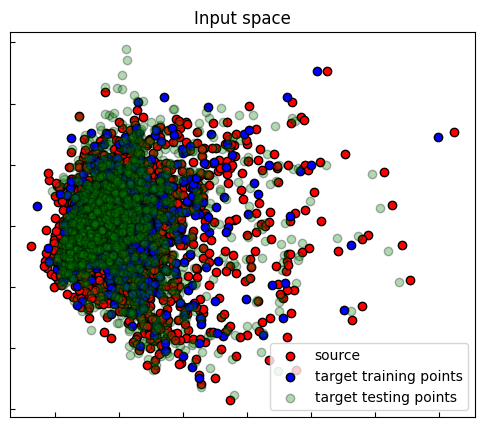

In [10]:
x_min, y_min = np.min([Xs_pca.min(0), Xt_pca.min(0)], 0)
x_max, y_max = np.max([Xs_pca.max(0), Xt_pca.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = pca.inverse_transform(np.stack([x_grid.ravel(), y_grid.ravel()], -1))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs_pca[:, 0], Xs_pca[:, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xt_lab_pca[:, 0], Xt_lab_pca[:, 1], label="target training points", edgecolors='k', c="blue")
ax1.scatter(Xt_pca[:, 0], Xt_pca[:, 1], label="target testing points", edgecolors='k', c="green", alpha=0.3)
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.savefig('input_scape.png')
plt.show()

In [11]:
rf = RandomForestRegressor(random_state=42)
# rf.fit(np.concatenate((Xs, Xt_lab)), np.concatenate((ys, yt_lab)))
rf.fit(Xs, ys)

/var/folders/l_/cjgh4zp97tx6xy5fhn4tzw9w0000gn/T/ipykernel_7412/3309392130.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Xs, ys)


RandomForestRegressor(random_state=42)

In [12]:
mean_absolute_error(rf.predict(Xt), yt.ravel())

5.494747567258158

In [13]:
score_src_src = rf.score(Xs, ys)
score_src_trgt = rf.score(Xt, yt)
print('Training score Source model: {:.3f}'.format(score_src_src))
print('Testing score Source model: {:.3f}'.format(score_src_trgt))

Training score Source model: 0.975
Testing score Source model: 0.843


In [14]:
from adapt.feature_based import FA
from adapt.instance_based import TrAdaBoostR2

In [15]:
model = FA(RandomForestRegressor(), Xt=Xt_lab, yt=yt_lab, random_state=0)
model.fit(Xs, ys)
model.score(Xt, yt)

Fit transform...
Previous shape: (2447, 10)
New shape: (3147, 30)
Fit Estimator...


0.839525585341563

In [16]:
# from adapt.instance_based import TrAdaBoostR2
model = TrAdaBoostR2(RandomForestRegressor(), Xt=Xt_lab, yt=yt_lab, random_state=0)
model.fit(Xs, ys)
model.score(Xt, yt)

Iteration 0 - Error: 0.0363
Iteration 1 - Error: 0.0526
Iteration 2 - Error: 0.0669
Iteration 3 - Error: 0.0933
Iteration 4 - Error: 0.1403
Iteration 5 - Error: 0.2484
Iteration 6 - Error: 0.2091
Iteration 7 - Error: 0.2687
Iteration 8 - Error: 0.2837
Iteration 9 - Error: 0.3337


0.8789692668658389

In [17]:
mean_absolute_error(model.predict(Xt).ravel(), yt.ravel())

5.180323411562679

In [272]:
model.score(Xt, yt)

0.8735814251693356

In [238]:
result = pd.DataFrame()

In [273]:
result['rf_adaptive'] = model.predict(Xt).ravel()
result['rf'] = rf.predict(Xt).ravel()
result['true'] = yt.ravel()

In [274]:
result.head(10)

,rf_adaptive,rf,true
0,23.842,20.398,45.0
1,22.136,21.115,43.3
2,37.508,36.658,42.5
3,15.450,9.598,41.7
4,20.158,18.916,40.9
5,36.536,37.913,40.0
6,34.798,36.708,39.2
7,34.628,33.672,38.4
8,38.454,38.190,35.9
9,33.847,34.559,34.3


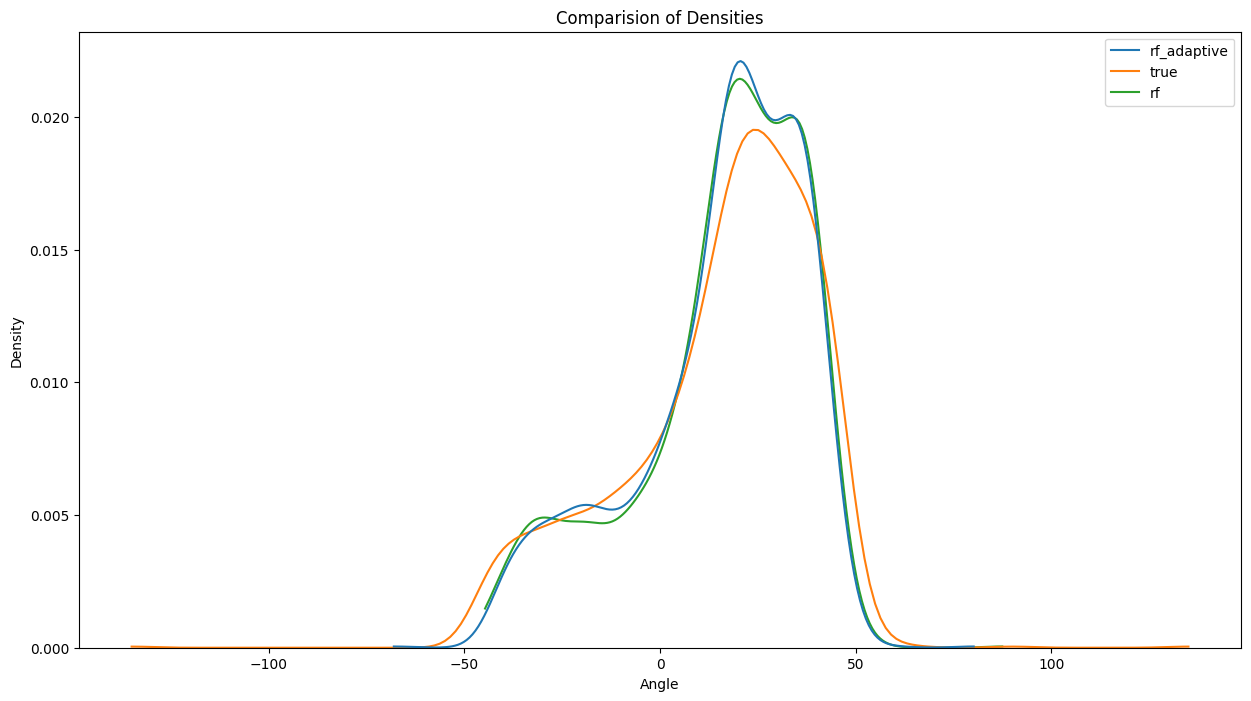

In [275]:
plt.figure(figsize=(15,8))
cols = ['rf_adaptive', 'true','rf']

# Without transparency
sns.kdeplot(data=result[cols],cut=0, fill=False, common_norm=False, alpha=1)
plt.xlabel('Angle')
plt.title('Comparision of Densities')
plt.savefig('rf_aadaprive_densities2.png')
plt.show()

In [276]:
df["MAE_rf"] = result.apply(lambda row: mean_absolute_error([row['rf']], [row['true']]), axis=1) 
df["MAE_rf_adaptive"] = result.apply(lambda row: mean_absolute_error([row['rf_adaptive']], [row['true']]), axis=1) 


In [277]:
cols = ['MAE_rf', 'MAE_rf_adaptive']
temp =df[cols] 
df_melted = temp.reset_index().melt(id_vars='index')

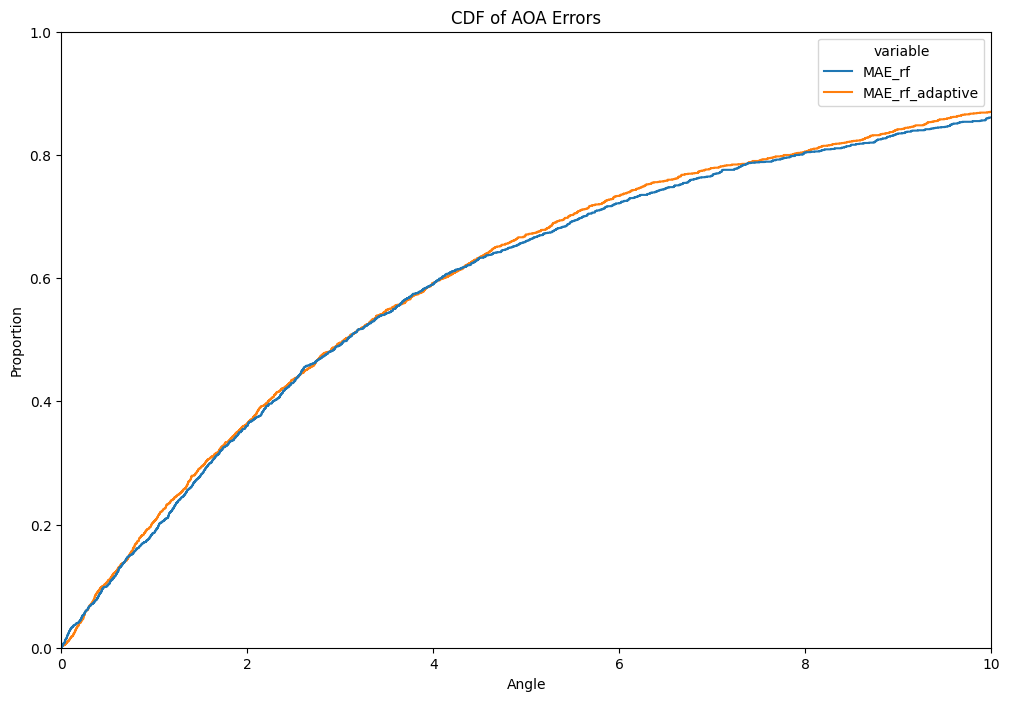

In [278]:
plt.figure(figsize=(12,8))
sns.ecdfplot(df_melted, x='value', hue='variable')
plt.xlim(0, 10)
plt.xlabel('Angle')
plt.title('CDF of AOA Errors')
plt.savefig('cdf_errors2.png')
plt.show()